## test to extract S1/S2 time series data <br>
data is retrieved in refelectance for Sentinel-2 and SIGMA for Sentinel-1. All data is scaled to UInt16 with nodata value set to 65535!
We also add the COP 30 DEM and METRO data (average temperature). The data is extracted for 1 year and temporal resampled to 10-daily intervals -> 36 time stamps per year.

In [1]:
import openeo
from extentmapping.openeo.preprocessing import ts_datacube_extraction
from extentmapping.config import get_job_options, get_collection_options, get_advanced_dataextraction_options
from extentmapping.utils import laea20km_id_to_extent, reproj_bbox_to_ll
import os
import json

C:\Users\BUCHHORM\Anaconda3\envs\extent\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### connect to the backend

In [2]:
# backend = 'terrascope'
backend = 'development'    # for current tests

# Make connection
if backend == 'terrascope':
    connection = openeo.connect("https://openeo.vito.be").authenticate_oidc()
elif backend == 'development':
    connection = openeo.connect("https://openeo-dev.vito.be").authenticate_oidc()
else:
    print('currently no specific connections to backends like creodias and sentinelhub are setup.')
    print('use standard entry point')
    connection = openeo.connect("https://openeo.cloud").authenticate_oidc()

Visit https://aai.egi.eu/device?user_code=NGPF-HLWD 📋 to authenticate.

[###################################--] Authorized successfully

Authenticated using device code flow.


### init the job, processing and collection option depending on provider and task

In [3]:
job_options = get_job_options(provider=backend, task='data_extraction')
collection_options = get_collection_options(provider=backend)
processing_options = get_advanced_dataextraction_options(provider=backend)

In [4]:
# just print for an overview
print(f'job_options: {job_options}')
print(f'collection_options: {collection_options}')
print(f'processing_options: {processing_options}')

job_options: {'driver-memory': '4G', 'driver-memoryOverhead': '4G', 'driver-cores': '2', 'executor-memory': '3G', 'executor-memoryOverhead': '2G', 'executor-cores': '2', 'max-executors': '50', 'soft-errors': 'true'}
collection_options: {'S2_collection': 'SENTINEL2_L2A', 'METEO_collection': 'AGERA5', 'S1_collection': 'SENTINEL1_GRD', 'DEM_collection': 'COPERNICUS_30'}
processing_options: {'provider': 'development', 's1_orbitdirection': 'DESCENDING', 'target_crs': 3035, 'resolution': 10.0, 'time_interpolation': False, 'ts_interval': 'dekad', 'SLC_masking_algo': 'mask_scl_dilation'}


### specify the space and time context

In [7]:
# the time context is given by start and end date
start = '2020-01-01'
end = '2021-01-01'   # the end is always exclusive

In [8]:
# the space context is defined as a bounding box dictionary with south,west,north,east and crs
# we take as example the AOI of Daniele's test for habitat mapping
AOI = {'east': 610240, 'south': 5689760, 'west': 600000, 'north': 5700000, 'crs': 'EPSG:32631'}

### we can also use the LAEA 20km grid for processing <br>
Either take directly the LAEA grid for processing, or if you have an AOI then we intersect and process all LAEA-20km tiles

In [10]:
import importlib.resources as importlib_resources
import geopandas as gpd
import extentmapping.resources

# get the LAEA-20km grid saved as EPSG:4326 vector
grid = importlib_resources.files(extentmapping.resources).joinpath('LAEA-20km.gpkg')
with grid.open('rb') as f:
    gdf = gpd.read_file(f, encoding='utf-8')
    
# reproject the AOI bbox to Lat/lon
AOI_ll = reproj_bbox_to_ll(AOI)

# spaitial intersect and retrieve the tile_ID's of the LAEA-20km grid
lTiles = gdf[gdf.intersects(AOI_ll)].name.unique().tolist()

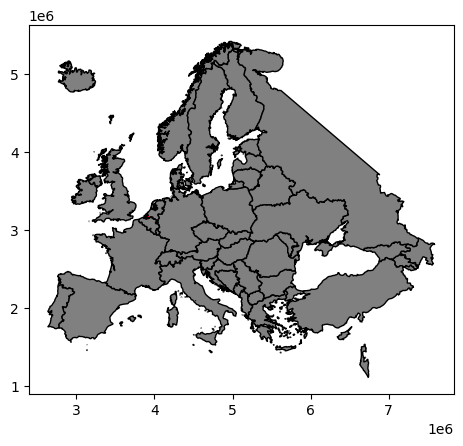

In [11]:
# just some visualization of the LAEA tiles to process
import requests
import matplotlib.pyplot as plt
url = 'https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson'
response = requests.get(url)
data = response.json()
europe = gpd.GeoDataFrame.from_features(data).set_crs(epsg=4326, allow_override=True).to_crs(3035)
fig,ax = plt.subplots()
europe.plot(color='grey', edgecolor='black', ax=ax)
gdf[gdf.name.isin(lTiles)].to_crs(3035).plot(color='red',ax=ax)
plt.show()

### run over the Tiles and process

In [12]:
# define the output folder root
out_root = os.path.normpath(r'C:\Users\BUCHHORM\OneDrive - VITO\Documents\Project_work\PEOPLE-EA\habitat_mapping\feature_extraction\test_v2')

In [14]:
for current_tile in lTiles:
    print(f'**** processing LAEA tile: {current_tile}')
    # get the bbox for this tile for processing
    processing_extent = laea20km_id_to_extent(current_tile)
    
    # define the job to get input data
    input_cube = ts_datacube_extraction(connection,
                                       processing_extent,
                                       start,
                                       end,
                                       **collection_options,
                                       **processing_options)
    
    # run it
    try:
        job = input_cube.execute_batch(title=str(current_tile),
                                      description='',
                                      out_format='NetCDF',
                                      job_options=job_options)
                
        # Get the results and save to output file
        results = job.get_results()
        
        # make sub-folder
        sub_folder = os.path.join(out_root, str(current_tile))
        os.makedirs(sub_folder, exist_ok=True)
        outputfile = os.path.join(sub_folder, f'timeseries_openeo_preprocessed_{current_tile}.nc')
        results.download_file(outputfile)
        # get metadata and job info
        with open(outputfile.replace('.nc','.json'), "w") as outfile:
            json.dump(results.get_metadata(),outfile)
        with open(outputfile.replace('.nc','-job.json'), "w") as outfile:
            json.dump(job.describe_job(),outfile)

    except Exception as e:
        print(e)

**** processing LAEA tile: E392N316
0:00:00 Job 'j-b4380be1646d4364a53755db803b2af0': send 'start'
0:00:22 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:00:27 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:00:34 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:00:42 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:00:52 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:01:04 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:01:21 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:01:40 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:02:04 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:02:36 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:03:14 Job 'j-b4380be1646d4364a53755db803b2af0': queued (progress N/A)
0:04:00 Job 'j-b4380be1646d4364a53755db803b2af0': running (progress N/A)
0:04:59 Job 'j-b4380be1646d4364a5375

In [13]:
# load data and check the last processed file
import xarray
ts = xarray.load_dataset(outputfile)
ts

<xarray.Dataset>
Dimensions:           (t: 36, x: 55, y: 55)
Coordinates:
  * t                 (t) datetime64[ns] 2020-01-01 2020-01-11 ... 2020-12-21
  * x                 (x) float64 3.935e+06 3.935e+06 ... 3.935e+06 3.935e+06
  * y                 (y) float64 3.163e+06 3.163e+06 ... 3.162e+06 3.162e+06
Data variables: (12/15)
    crs               |S1 b''
    B02               (t, y, x) uint16 376 451 449 372 ... 65535 65535 65535
    B03               (t, y, x) uint16 464 508 512 473 ... 65535 65535 65535
    B04               (t, y, x) uint16 574 672 637 523 ... 65535 65535 65535
    B05               (t, y, x) uint16 757 886 886 622 ... 65535 65535 65535
    B06               (t, y, x) uint16 1009 1119 1119 783 ... 65535 65535 65535
    ...                ...
    B11               (t, y, x) uint16 1537 1623 1623 1108 ... 65535 65535 65535
    B12               (t, y, x) uint16 1134 1169 1169 795 ... 65535 65535 65535
    VH                (t, y, x) uint16 1110 1022 992 1033 ... 3302 2498 2080
    VV                (t, y, x) uint16 3067 3188 3545 3104 ... 5288 5471 4513
    temperature_mean  (t, y, x) uint16 27994 27994 27994 ... 27880 27880 27880
    DEM               (t, y, x) uint16 12 12 12 12 12 12 ... 27 27 28 29 29 28
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.17.0a1
    description:  
    title: